In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import database as db
from datetime import timedelta

import anomaly_detection as ao

sns.set()

In [2]:
def run_anomalies(df, run_date, social_mod=None,
                  limit=95, horizon=12, simulations=10):   

    all_forcs = ao.anomaly_wrapper(df, run_date, horizon,
                                   simulations=simulations,
                                   social_mod=social_mod)

    forcs_df = (all_forcs.groupby(['region', 'cutoff', 'ds'])
                ['percent_ill']
                .describe(percentiles=[.025, 0.05, .1, .25, .5, .75, .9, .95, .975])
                .reset_index())

    # Be sure to grab the correct percentile...
    limit_dict = {90: '95%', 95: '97.5%'}

    forcs_df = forcs_df.merge(df[['region', 'percent_ill', 'ds']],
                              on=['region', 'ds'], how='outer')

    forcs_df['anomaly_diff'] = (forcs_df['percent_ill']
                                - forcs_df[limit_dict[limit]])
    forcs_df['anomaly_ili'] = np.where(forcs_df['anomaly_diff'] > 0,
                                       forcs_df['percent_ill'], np.nan)

    # Only keep the significant anomaly differences
    forcs_df['anomaly_diff'] = (forcs_df['anomaly_ili'] -
                                forcs_df[limit_dict[limit]])
    forcs_df['anomaly_diff'] = forcs_df['anomaly_diff'].fillna(0)
    
    return forcs_df


In [3]:
# Create the Brooklyn, NY ensemble forecasting and anomaly detection example...
bk_df = pd.read_csv('data/brooklyn.csv')
bk_df['ds'] = pd.to_datetime(bk_df['ds'])

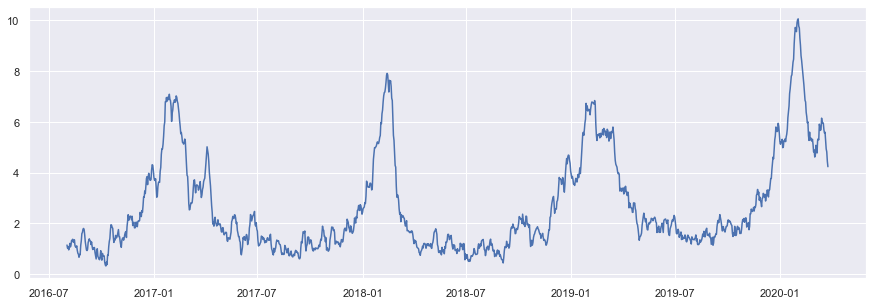

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(bk_df['ds'], bk_df['percent_ill'])

In [31]:
bk100 = run_anomalies(bk_df, ['2020-03-01'], simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


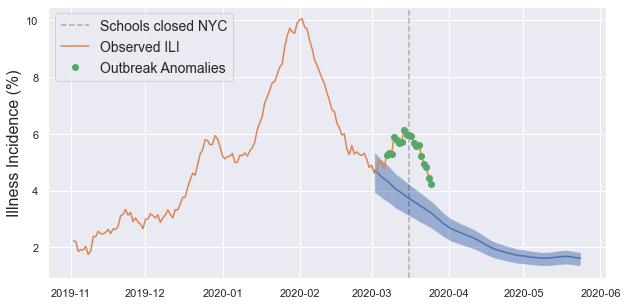

In [76]:
### Figure 2: Example detection in Brooklyn, NY
sub = bk100[bk100.ds > '2019-11-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Illness Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.savefig('Figure 2.png', dpi=300);

In [34]:
bk_distancing = run_anomalies(bk_df, ['2020-03-01'], social_mod=0.85, simulations=100)

Forecasting for 36047


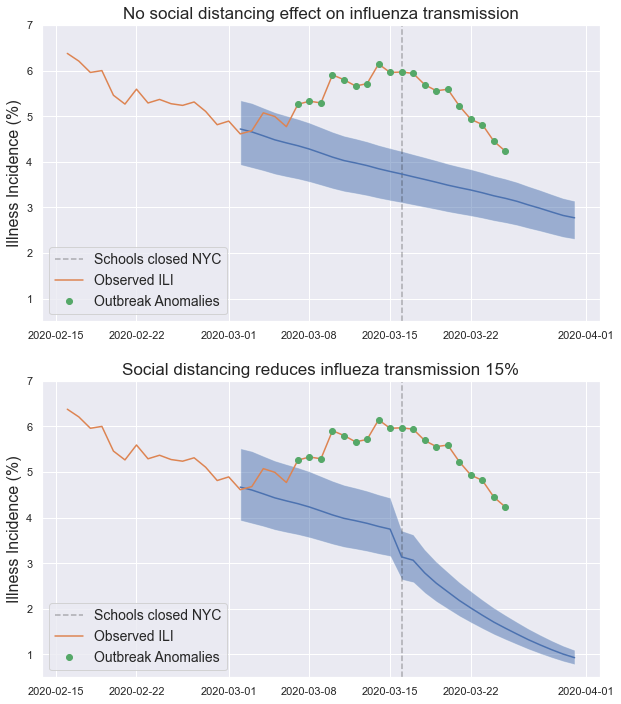

In [75]:
### Social distancing estimate in Brooklyn
bk_85 = bk_distancing[(bk_distancing.ds > '2020-02-15') &
                      (bk_distancing.ds < '2020-04-01')].copy()
bk_85.sort_values('ds', inplace=True)

bk_100 = bk100[(bk100.ds > '2020-02-15') &
               (bk100.ds < '2020-04-01')].copy()
bk_100.sort_values('ds', inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

ax[0].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
ax[0].fill_between(bk_100.ds, bk_100['97.5%'], bk_100['2.5%'], alpha=0.5)
ax[0].plot(bk_100.ds, bk_100['50%'], label='')
ax[0].plot(bk_100.ds, bk_100.percent_ill, label='Observed ILI')
ax[0].plot(bk_100.ds, bk_100.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[1].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
ax[1].fill_between(bk_85.ds, bk_85['97.5%'], bk_85['2.5%'], alpha=0.5)
ax[1].plot(bk_85.ds, bk_85['50%'], label='')
ax[1].plot(bk_85.ds, bk_85.percent_ill, label='Observed ILI')
ax[1].plot(bk_85.ds, bk_85.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[0].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[1].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[0].legend(fontsize=14, loc='lower left')
ax[1].legend(fontsize=14, loc='lower left')
ax[0].set_title('No social distancing effect on influenza transmission', fontsize=17)
ax[1].set_title('Social distancing reduces influeza transmission 15%', fontsize=17)
ax[0].set_ylim(0.5, 7)
ax[1].set_ylim(0.5, 7)
plt.savefig('Figure S1.png', dpi=300)

In [46]:
## Now for the Santa Clara example
sc_df = pd.read_csv('data/santa_clara.csv')
sc_df['ds'] = pd.to_datetime(sc_df['ds'])

In [49]:
sc100 = run_anomalies(sc_df, ['2020-03-01'], simulations=100)
sc_distancing = run_anomalies(sc_df, ['2020-03-01'], social_mod=0.85, simulations=100)

Forecasting for 6085
Forecasting for 6085


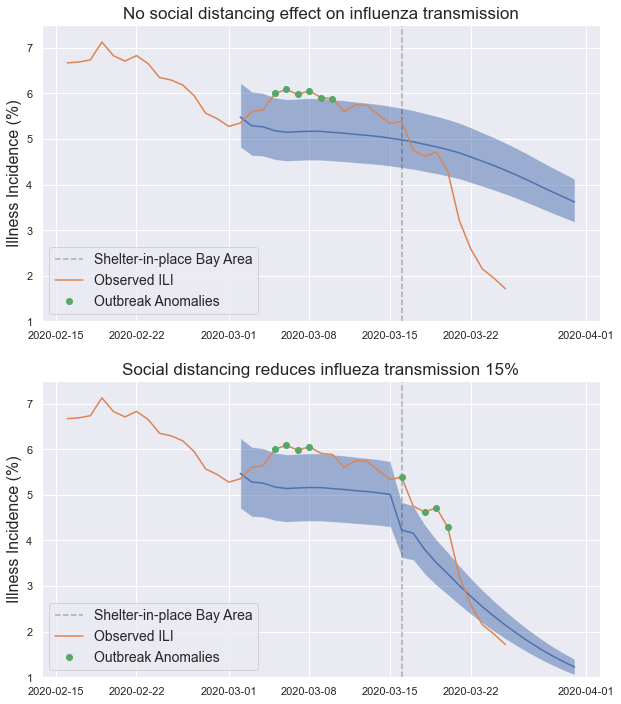

In [74]:
### Social distancing example in Santa Clara, CA
sc_85 = sc_distancing[(sc_distancing.ds > '2020-02-15') &
                      (sc_distancing.ds < '2020-04-01')].copy()
sc_85.sort_values('ds', inplace=True)

sc_100 = sc100[(sc100.ds > '2020-02-15') &
               (sc100.ds < '2020-04-01')].copy()
sc_100.sort_values('ds', inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

ax[0].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[0].fill_between(sc_100.ds, sc_100['97.5%'], sc_100['2.5%'], alpha=0.5)
ax[0].plot(sc_100.ds, sc_100['50%'], label='')
ax[0].plot(sc_100.ds, sc_100.percent_ill, label='Observed ILI')
ax[0].plot(sc_100.ds, sc_100.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[1].axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area')
ax[1].fill_between(sc_85.ds, sc_85['97.5%'], sc_85['2.5%'], alpha=0.5)
ax[1].plot(sc_85.ds, sc_85['50%'], label='')
ax[1].plot(sc_85.ds, sc_85.percent_ill, label='Observed ILI')
ax[1].plot(sc_85.ds, sc_85.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

ax[0].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[1].set_ylabel('Illness Incidence (%)', fontsize=16)
ax[0].legend(fontsize=14, loc='lower left')
ax[1].legend(fontsize=14, loc='lower left')
ax[0].set_title('No social distancing effect on influenza transmission', fontsize=17)
ax[1].set_title('Social distancing reduces influeza transmission 15%', fontsize=17)
ax[0].set_ylim(1, 7.5)
ax[1].set_ylim(1, 7.5)
plt.savefig('Figure S2.png', dpi=300)

In [77]:
# Now, how does this effect our correlations to COVID cases?
# Well, in Brooklyn we don't have easily available counts, so we will run a sensitivity analysis
# across a range of reduced transmission rates to assess the impact on correlations
covid = pd.read_csv('data/timeseries-jhu.csv')

sc_covid = covid[(covid.county == 'Santa Clara County')]
sc_covid= sc_covid.drop(['lat', 'long', 'city', 'state', 'country', 'population', 'url'], axis=1)
sc_covid = sc_covid.melt(id_vars='county', var_name='ds', value_name='cases')
sc_covid['ds'] = pd.to_datetime(sc_covid.ds, format='%Y-%m-%d')
sc_covid = sc_covid[sc_covid.ds > '2020-03-01']

# complete COVID data from JHU is only available for the entire state
ny_covid = covid[(covid.state == 'NY') & (covid.county.isna()) & (covid.city.isna())]
ny_covid= ny_covid.drop(['lat', 'long', 'city', 'county', 'country', 'population', 'url'], axis=1)
ny_covid = ny_covid.melt(id_vars='state', var_name='ds', value_name='cases')
ny_covid['ds'] = pd.to_datetime(ny_covid.ds, format='%Y-%m-%d')
ny_covid = ny_covid[ny_covid.ds > '2020-03-01']

In [78]:
# Now, let's look at how the correlations between cumulative anomaly incidence
# and total COVID cases vary with distancing reductions in transmission
# look at reductions down to 25% below standard

dfs = []

for distance in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    print(f'Running distancing at {distance}')
    out = run_anomalies(bk_df, ['2020-03-01'], social_mod=distance, simulations=50)
    out['distancing'] = 1 - distance
    dfs.append(out)
    
bk_distancing = pd.concat(dfs, axis=0)

Running distancing at 1
Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Running distancing at 0.95
Forecasting for 36047
Running distancing at 0.9
Forecasting for 36047
Running distancing at 0.85
Forecasting for 36047
Running distancing at 0.8
Forecasting for 36047
Running distancing at 0.75
Forecasting for 36047


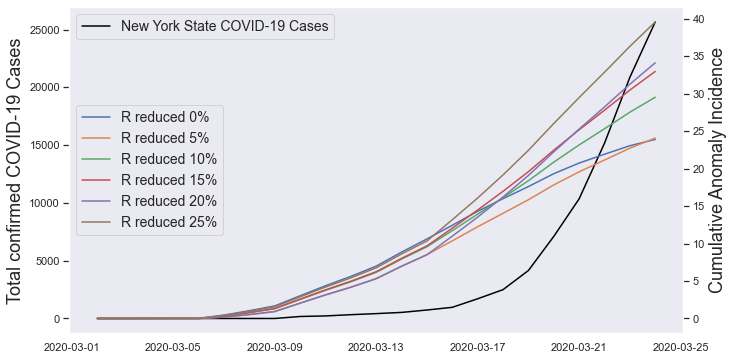

In [179]:
ny_input = bk_distancing[(bk_distancing.ds >= ny_covid.ds.min()) &
                         (bk_distancing.ds <= ny_covid.ds.max())]
fig, ax1 = plt.subplots(figsize=(11, 6))

ax2 = ax1.twinx()
for distancing in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    sub = ny_input[ny_input.distancing == (1 - distancing)].copy()
    sub['cumulative_anom'] = sub['anomaly_diff'].cumsum()
    sub.sort_values('ds', inplace=True)
    ax2.plot(sub.ds, sub.cumulative_anom,
             label=f'R reduced {round((1 - distancing)*100)}%')
ax1.plot(ny_covid.ds, ny_covid.cases, color='black', label='New York State COVID-19 Cases')

ax1.set_xlabel('')
ax1.set_ylabel('Total confirmed COVID-19 Cases', fontsize=18)
ax2.set_ylabel('Cumulative Anomaly Incidence', fontsize=18)
ax1.grid(False)
ax2.grid(False)
ax1.legend(fontsize=14)
ax2.legend(loc='center left', fontsize=14)
plt.savefig('Figure S4.png', dpi=300)

In [85]:
# Now, let's look at how the correlations between cumulative anomaly incidence
# and total COVID cases vary with distancing reductions in transmission
# look at reductions down to 25% below standard

dfs = []

for distance in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    print(f'Running distancing at {distance}')
    out = run_anomalies(sc_df, ['2020-03-01'], social_mod=distance, simulations=50)
    out['distancing'] = 1 - distance
    dfs.append(out)
    
sc_distancing = pd.concat(dfs, axis=0)

Running distancing at 1
Forecasting for 6085


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Running distancing at 0.95
Forecasting for 6085
Running distancing at 0.9
Forecasting for 6085
Running distancing at 0.85
Forecasting for 6085
Running distancing at 0.8
Forecasting for 6085
Running distancing at 0.75
Forecasting for 6085


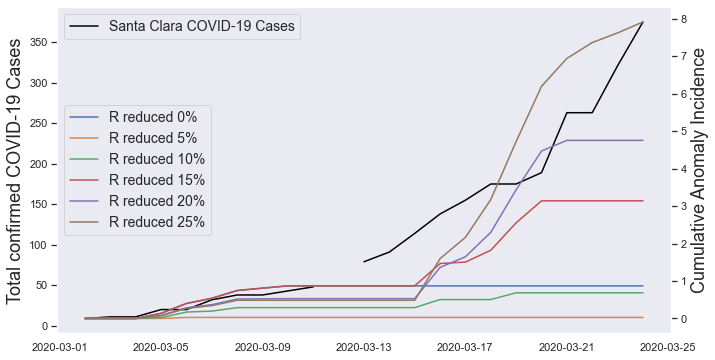

In [180]:
sc_input = sc_distancing[(sc_distancing.ds >= sc_covid.ds.min()) &
                         (sc_distancing.ds <= sc_covid.ds.max())]

fig, ax1 = plt.subplots(figsize=(11, 6))
ax2 = ax1.twinx()
for distancing in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    sub = sc_input[sc_input.distancing == (1 - distancing)].copy()
    sub['cumulative_anom'] = sub['anomaly_diff'].cumsum()
    sub.sort_values('ds', inplace=True)
    ax2.plot(sub.ds, sub.cumulative_anom,
             label=f'R reduced {round((1 - distancing)*100)}%')
ax1.plot(sc_covid.ds, sc_covid.cases, color='black', label='Santa Clara COVID-19 Cases')

ax1.set_xlabel('')
ax1.set_ylabel('Total confirmed COVID-19 Cases', fontsize=18)
ax2.set_ylabel('Cumulative Anomaly Incidence', fontsize=18)
ax1.grid(False)
ax2.grid(False)
ax1.legend(fontsize=14)
ax2.legend(loc='center left', fontsize=14)
plt.savefig('Figure S3.png', dpi=300)

In [146]:
## How do these changes in R correlate to overall COVID cases per region
# For Santa Clara
sc_cumm = (sc_input.groupby(['ds', 'distancing'])['anomaly_diff']
           .mean()
           .groupby('distancing').cumsum()
           .to_frame().reset_index()
           .merge(sc_covid, on='ds'))

# And Brooklyn to NY State comparison
ny_cumm = (ny_input.groupby(['ds', 'distancing'])['anomaly_diff']
           .mean()
           .groupby('distancing').cumsum()
           .to_frame().reset_index()
           .merge(ny_covid, on='ds'))

# Get pearson correlation per state series between anomalies and COVID cases
corr_sc = (sc_cumm.groupby('distancing')
          ['anomaly_diff', 'cases']
          .corr(method='pearson')
          .unstack().reset_index())

corr_ny = (ny_cumm.groupby('distancing')
          ['anomaly_diff', 'cases']
          .corr(method='pearson')
          .unstack().reset_index())

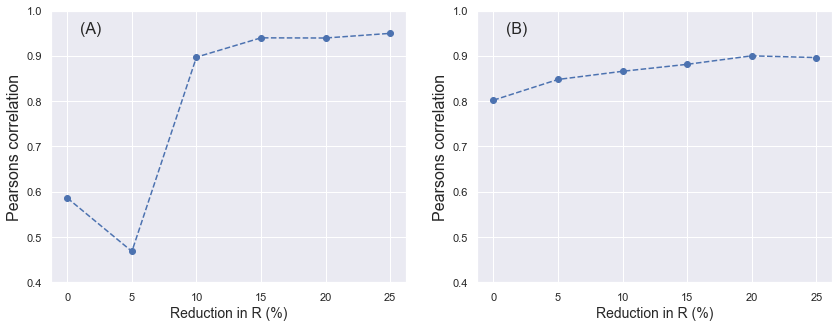

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(corr_sc['distancing']*100, corr_sc['anomaly_diff']['cases'], linestyle='--', marker='o',)
ax[0].set_ylabel('Pearsons correlation', fontsize=16)
ax[0].set_xlabel('Reduction in R (%)', fontsize=14)

ax[1].plot(corr_ny['distancing']*100, corr_ny['anomaly_diff']['cases'], linestyle='--', marker='o',)
ax[1].set_ylabel('Pearsons correlation', fontsize=16)
ax[1].set_xlabel('Reduction in R (%)', fontsize=14);
ax[0].set_ylim(0.4, 1)
ax[1].set_ylim(0.4, 1)
ax[0].text(1, .95, '(A)', fontsize=16)
ax[1].text(1, .95, '(B)', fontsize=16)
plt.savefig('Figure S5.png', dpi=300)